Analyse uitvoeren met mijn raster  per buurt.

In [2]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_HALF_UP

Buurten en raster inladen


Waterpixels tellen: 100%|██████████| 111/111 [00:16<00:00,  6.69it/s]


Top 10 buurten met meeste water (m²):
                         buurt     water_m2
31    Schoteroog en Veerpolder  713155.6875
83               Oud Spaarndam  281770.4375
110               Meerwijkplas  279983.4375
30               Waarderpolder  246141.9375
103                  Molenplas  167657.3125
73     Spaarndammerpolder-zuid  163417.6875
97        Zuid-Schalkwijkerweg  139157.3750
88                 De Eenhoorn  105084.9375
42   Buitengebied Zuiderpolder  102377.0625
107            Poelpolder-zuid   68694.6875


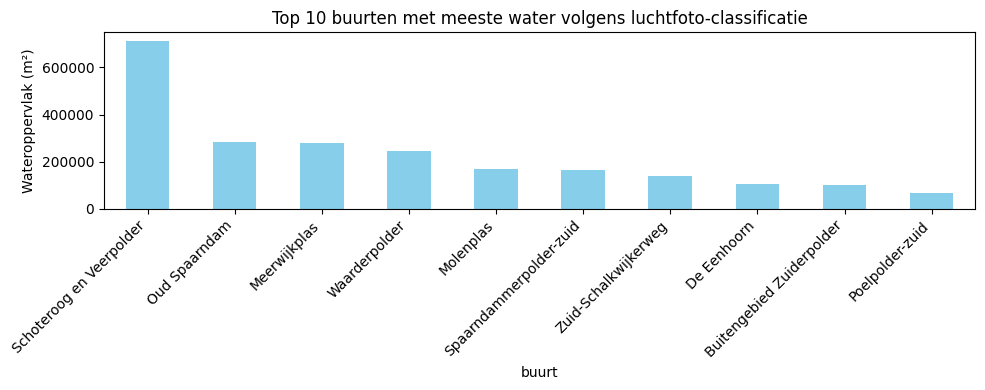

In [21]:
# Padinstellingen
raster_path = "../qgis/haarlem_met_water_corrected.tif"
buurten_path = "../qgis/buurten_haarlem.gpkg"
water_class = 3
nodata = 255

# Data inladen
print("Buurten en raster inladen")
gdf = gpd.read_file(buurten_path).to_crs("EPSG:28992")

water_counts = []

with rasterio.open(raster_path) as src:
    transform = src.transform
    band = src.read(1)

    for _, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Waterpixels tellen"):
        buurt_naam = row["buurtnaam"]
        geom = [row.geometry]

        try:
            out_image, _ = mask(src, geom, crop=True, nodata=nodata)
            values = out_image[0]
            values = values[values != nodata]
            count = int(np.sum(values == water_class))
        except Exception as e:
            print(f"Fout bij {buurt_naam}: {e}")
            count = 0

        water_counts.append({"buurt": buurt_naam, "waterpixels": count})

# DataFrame maken
df = pd.DataFrame(water_counts)
df["water_m2"] = df["waterpixels"] * 0.25**2  # resolutie = 0.25 m
df_sorted = df.sort_values("water_m2", ascending=False)

# Top 10 bekijken
print("Top 10 buurten met meeste water (m²):")
print(df_sorted[["buurt", "water_m2"]].head(10))

# Barplot
df_sorted.head(10).plot(kind="bar", x="buurt", y="water_m2", legend=False, color="skyblue", figsize=(10, 4))
plt.ylabel("Wateroppervlak (m²)")
plt.title("Top 10 buurten met meeste water volgens luchtfoto-classificatie")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("../output/figures/top10_water_luchtfoto.png", dpi=300, bbox_inches="tight")
plt.show()


In [5]:
# Padinstellingen
raster_path = "../qgis/haarlem_met_water_corrected.tif"
bgt_path = "../qgis/bgt_op_oorsprong_samengevoegd.gpkg"
buurten_path = "../qgis/buurten_haarlem.gpkg"
output_csv = "../output/excel/combined_buurt_analyse.csv"
nodata = 255

# Buurten inladen
print("Buurten inladen")
buurten = gpd.read_file(buurten_path).rename(columns=str.lower)
buurten = buurten.to_crs(epsg=28992)

# Rasteranalyse per buurt
print("Rasteranalyse uitvoeren")
raster_rows = []

with rasterio.open(raster_path) as src:
    band = src.read(1)
    buurten = buurten.to_crs(src.crs)

    for _, row in tqdm(buurten.iterrows(), total=len(buurten), desc="Raster per buurt"):
        geom = row.geometry
        try:
            mask_arr, _ = mask(src, [geom], crop=True, nodata=nodata)
            vals = mask_arr[0]
            vals = vals[vals != nodata]

            pixel_area = abs(src.res[0] * src.res[1])
            counts = pd.Series(vals).value_counts()

            groen = counts.get(1, 0) * pixel_area
            verhard = counts.get(2, 0) * pixel_area
            water = counts.get(3, 0) * pixel_area
            totaal = groen + verhard + water

            raster_rows.append({
                "buurt": row["buurtnaam"],
                "raster_groen_m2": groen,
                "raster_verhard_m2": verhard,
                "raster_water_m2": water,
                "raster_groen_pct": 100 * groen / totaal if totaal > 0 else np.nan,
                "raster_verhard_pct": 100 * verhard / totaal if totaal > 0 else np.nan,
                "raster_water_pct": 100 * water / totaal if totaal > 0 else np.nan,
                "raster_groen_per_inw": groen / row["aantal_inwoners"] if row["aantal_inwoners"] else np.nan,
                "raster_groen_per_hh": groen / row["aantal_huishoudens"] if row["aantal_huishoudens"] else np.nan,
            })
        except Exception as e:
            print(f"Fout bij buurt '{row['buurtnaam']}': {e}")

df_raster = pd.DataFrame(raster_rows)

# BGT-analyse per buurt
print("BGT-analyse uitvoeren")
bgt = gpd.read_file(bgt_path).to_crs(buurten.crs)
bgt["oppervlakte"] = bgt.geometry.area

def herclassificeer(o):
    if o in ["begroeid"]:
        return "groen"
    elif o in ["onbegroeid", "panden", "weg", "water ondersteunend", "weg ondersteunend"]:
        return "verhard"
    elif o == "water":
        return "water"
    return "onbekend"

bgt["categorie"] = bgt["oorsprong"].apply(herclassificeer)

bgt_rows = []

for _, row in tqdm(buurten.iterrows(), total=len(buurten), desc="BGT per buurt"):
    geom = row.geometry
    try:
        bgt_in_buurt = bgt[bgt.geometry.intersects(geom)].copy()
        bgt_in_buurt["intersectie"] = bgt_in_buurt.geometry.intersection(geom)
        bgt_in_buurt["opp_in_buurt"] = bgt_in_buurt["intersectie"].area

        agg = bgt_in_buurt.groupby("categorie")["opp_in_buurt"].sum()

        groen = agg.get("groen", 0)
        verhard = agg.get("verhard", 0)
        water = agg.get("water", 0)
        totaal = groen + verhard + water

        bgt_rows.append({
            "buurt": row["buurtnaam"],
            "bgt_groen_m2": groen,
            "bgt_verhard_m2": verhard,
            "bgt_water_m2": water,
            "bgt_groen_pct": 100 * groen / totaal if totaal > 0 else np.nan,
            "bgt_verhard_pct": 100 * verhard / totaal if totaal > 0 else np.nan,
            "bgt_water_pct": 100 * water / totaal if totaal > 0 else np.nan,
            "bgt_groen_per_inw": groen / row["aantal_inwoners"] if row["aantal_inwoners"] else np.nan,
            "bgt_groen_per_hh": groen / row["aantal_huishoudens"] if row["aantal_huishoudens"] else np.nan,
        })
    except Exception as e:
        print(f"Fout bij buurt '{row['buurtnaam']}': {e}")

df_bgt = pd.DataFrame(bgt_rows)

# Voeg aantal inwoners, huishoudens en buurtoppervlak toe
buurt_info = buurten[["buurtnaam", "aantal_inwoners", "aantal_huishoudens"]].copy()
buurt_info["oppervlakte_buurt"] = buurten.geometry.area
buurt_info = buurt_info.rename(columns={"buurtnaam": "buurt"})

# Combineren & exporteren
print("Data combineren...")
combined = df_raster.merge(df_bgt, on="buurt", how="outer")
combined = combined.merge(buurt_info, on="buurt", how="left")

# Afronden
afrond_cols = [col for col in combined.columns if any(t in col for t in ["m2", "_per_", "_pct"])]
combined[afrond_cols] = combined[afrond_cols].applymap(lambda x: round(x, 2) if pd.notnull(x) else x)

# Exporteren
os.makedirs(os.path.dirname(output_csv), exist_ok=True)
combined.to_csv(output_csv, index=False, sep=";", decimal=",")
print("Bestand opgeslagen als:", output_csv)



Buurten inladen
Rasteranalyse uitvoeren


Raster per buurt: 100%|██████████| 111/111 [00:20<00:00,  5.40it/s]


BGT-analyse uitvoeren


BGT per buurt: 100%|██████████| 111/111 [00:50<00:00,  2.20it/s]

Data combineren...
Bestand opgeslagen als: ../output/excel/combined_buurt_analyse.csv



C:\Users\Aaron\AppData\Local\Temp\ipykernel_10344\2733920348.py:112: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined[afrond_cols] = combined[afrond_cols].applymap(lambda x: round(x, 2) if pd.notnull(x) else x)


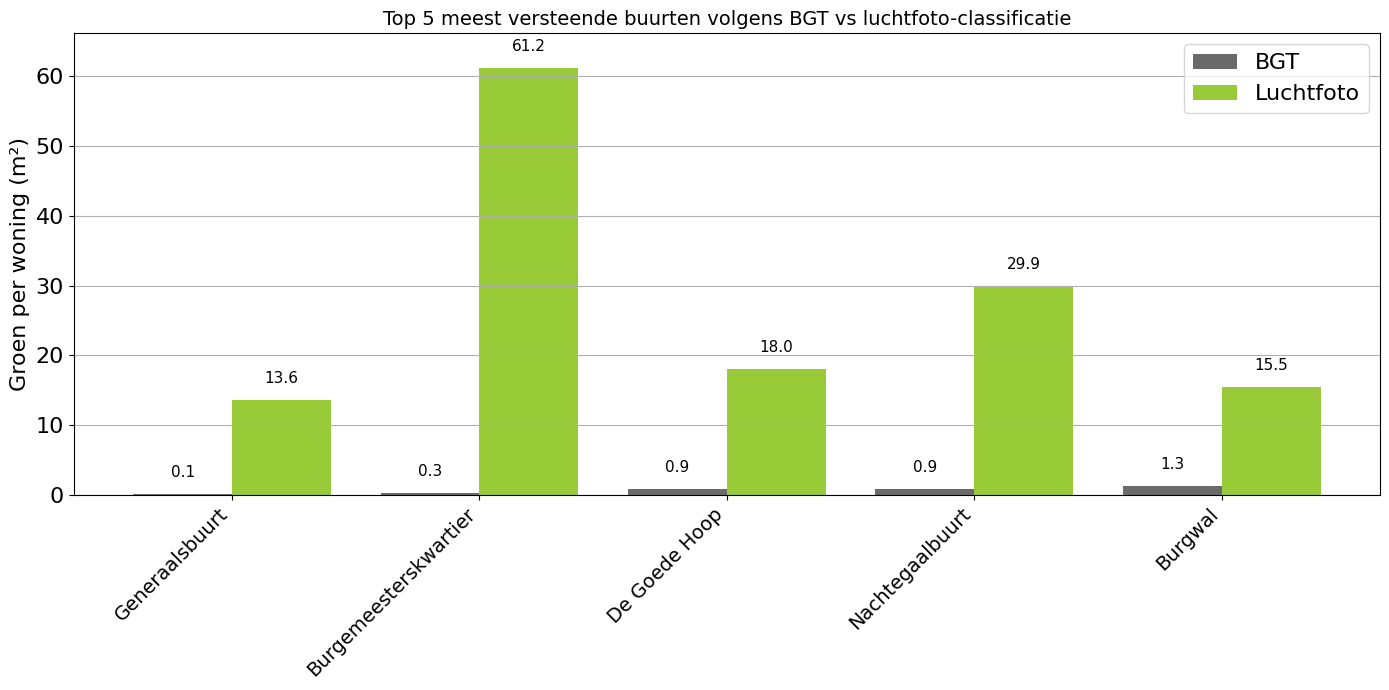

In [16]:
# Data inladen
df = pd.read_csv("../output/excel/combined_buurt_analyse.csv", sep=";", decimal=",")
df = df[df["bgt_groen_per_hh"].notna() & df["raster_groen_per_hh"].notna()]

# Top 5 minst groene buurten volgens BGT
bottom10 = df.sort_values("bgt_groen_per_hh", ascending=True).head(5)

# Plot
plt.figure(figsize=(14, 7))
x = bottom10["buurt"]
bar_width = 0.4
indices = range(len(x))

# Balken tekenen
bars_bgt = plt.bar(
    [i for i in indices],
    bottom10["bgt_groen_per_hh"],
    width=bar_width,
    label="BGT",
    color="#6a6a6a",
    align="center"
)

bars_raster = plt.bar(
    [i + bar_width for i in indices],
    bottom10["raster_groen_per_hh"],
    width=bar_width,
    label="Luchtfoto",
    color="#99cb38",
    align="center"
)

# Waarden boven de balken tekenen
for bar in bars_bgt:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        f"{Decimal(str(height)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)}",
        ha='center', va='bottom', fontsize=11
    )

for bar in bars_raster:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        f"{Decimal(str(height)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)}",
        ha='center', va='bottom', fontsize=11
    )

# Aankleding
plt.ylabel("Groen per woning (m²)", fontsize=16)
plt.title("Top 5 meest versteende buurten volgens BGT vs luchtfoto-classificatie", fontsize=14)
plt.xticks([i + bar_width / 2 for i in indices], x, rotation=45, ha="right", fontsize=14)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid(axis="y")
plt.tight_layout()

# Zorg voor voldoende ruimte boven de hoogste waarde
max_val = bottom10[["bgt_groen_per_hh", "raster_groen_per_hh"]].max().max()
plt.ylim(top=max_val + 5)
plt.savefig("../output/figures/top5_versteend_BGT_vs_luchtfoto.png", dpi=300, bbox_inches="tight")
plt.show()


                     buurt  raster_groen_per_hh
3               Binnenstad                13.44
26          Generaalsbuurt                13.60
74       Rozenprieel-noord                15.33
11                 Burgwal                15.48
16           De Goede Hoop                18.02
75        Rozenprieel-zuid                21.15
100               Vijfhoek                21.54
30            Heiliglanden                21.73
59   Oude Amsterdamsebuurt                22.07
2                  Bakenes                23.02


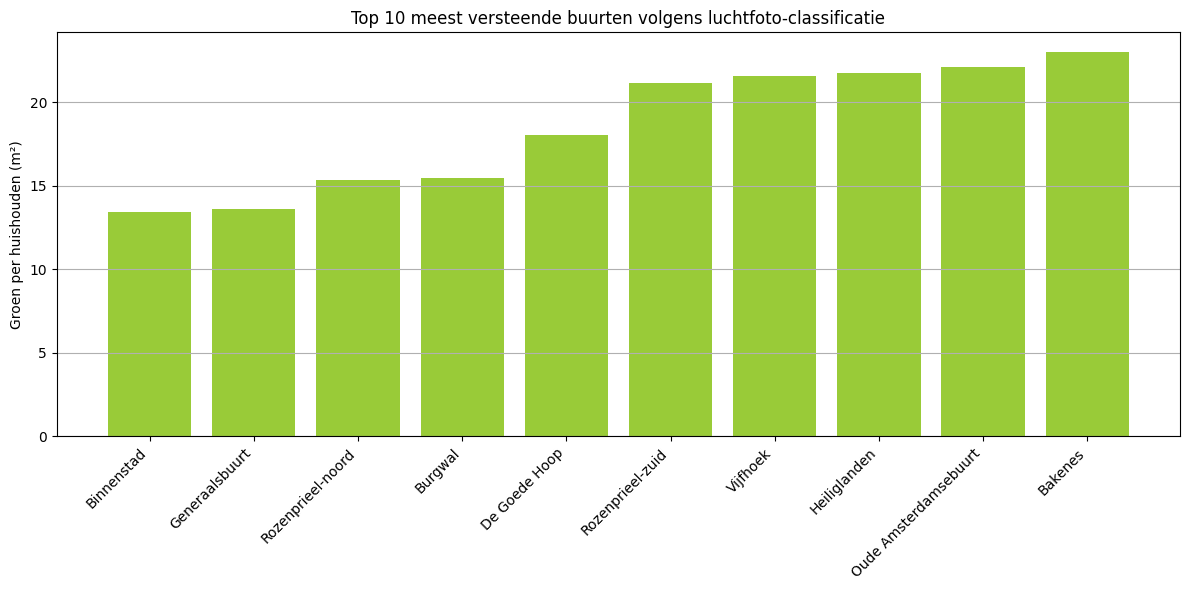

In [20]:
# CSV-bestand inladen
df = pd.read_csv("../output/excel/combined_buurt_analyse.csv", sep=";", decimal=",")

# Filter op buurten waar groenwaarde uit rasteranalyse beschikbaar is
df_filtered = df[df["raster_groen_per_hh"].notna()]

# Sorteer oplopend: minst groen per huishouden eerst
top10_versteend = df_filtered.sort_values("raster_groen_per_hh", ascending=True).head(10)

# Toon resultaat
print(top10_versteend[["buurt", "raster_groen_per_hh"]])

plt.figure(figsize=(12, 6))
plt.bar(top10_versteend["buurt"], top10_versteend["raster_groen_per_hh"], color="#99cb38")
plt.ylabel("Groen per huishouden (m²)")
plt.title("Top 10 meest versteende buurten volgens luchtfoto-classificatie")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("../output/figures/top10_versteend_luchtfoto.png", dpi=300, bbox_inches="tight")
plt.show()
